## 복잡도 파라미터 튜닝 개요
- 복잡도 파라미터란 복잡도에 영향을 주는 파라미터로, 이 값에 따라 과적합 정도가 결정되므로 매우 신중하게 튜닝해야함

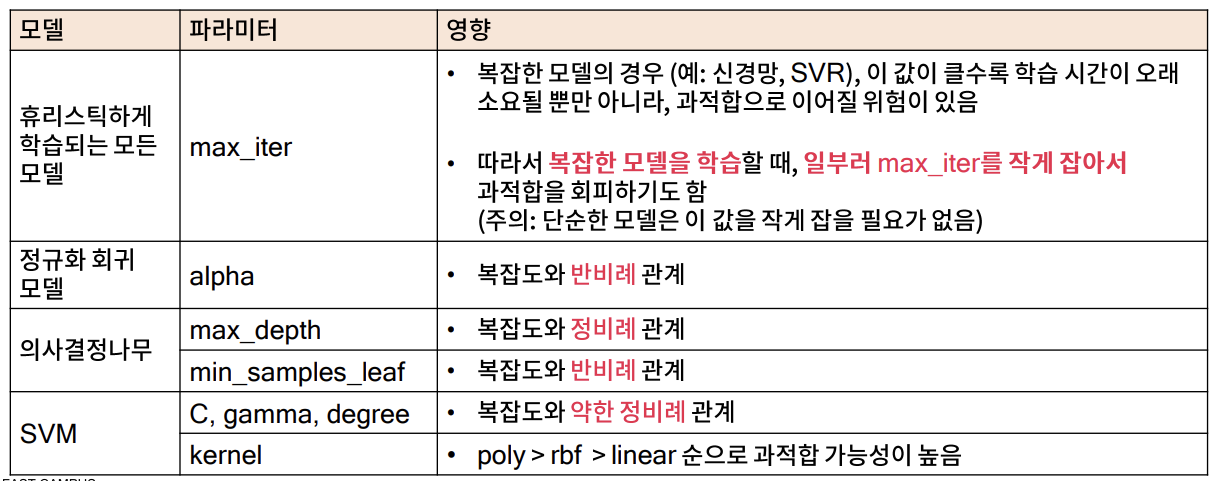

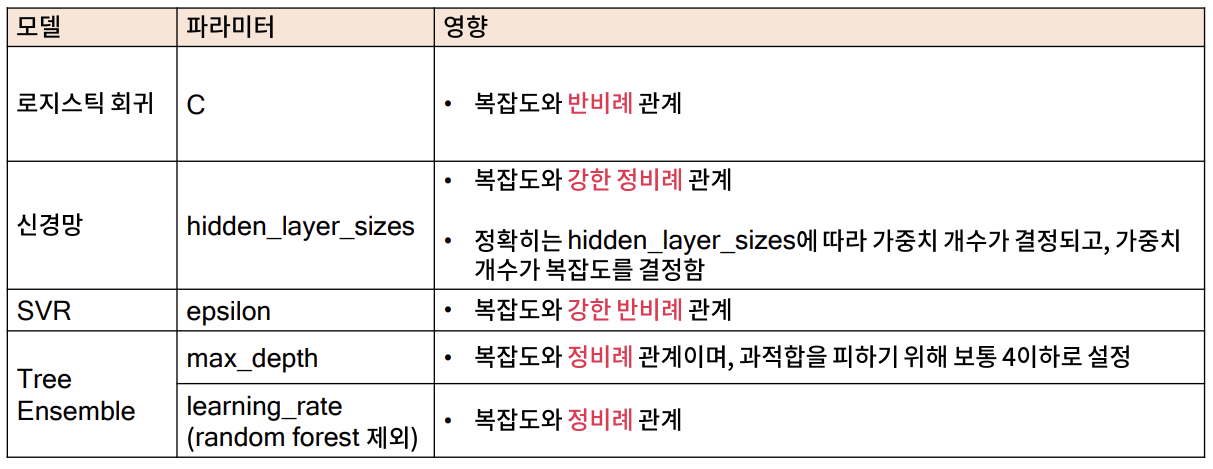

In [1]:
# 데이터 경로 설정 및 데이터 불러오기
import os
os.chdir(r"C:\Users\신상훈\Desktop\preprocessing\part-3.-지도학습-주요모델-및-개념\Part 3. 지도학습 주요모델 및 개념\데이터")

import pandas as pd
import numpy as np
df = pd.read_csv("Sonar_Mines_Rocks.csv")

In [2]:
# 특징과 라벨 분리
X = df.drop('Y', axis = 1)
Y = df['Y']

In [3]:
# 학습 데이터와 평가 데이터 분리
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [4]:
Train_X.shape # 샘플 156개, 특징 60개 => 단순한 모델 필요

(156, 60)

In [5]:
Train_Y.value_counts()

M    83
R    73
Name: Y, dtype: int64

In [6]:
Train_Y.replace({"M":-1, "R":1}, inplace = True)
Test_Y.replace({"M":-1, "R":1}, inplace = True)

In [7]:
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

#### Case 1. 복잡도 파라미터가 한 개이면서, 단순하고, 우연성이 어느정도 있는 모델 (Logistic Regression)

In [8]:
from sklearn.linear_model import LogisticRegression as LR

In [9]:
def LR_model_test(C):
    model = LR(C = C, max_iter = 100000, random_state = 10).fit(Train_X, Train_Y) # 가벼운 모델이므로 max_iter를 크게 잡음
    pred_Y = model.predict(Test_X)
    return f1_score(Test_Y, pred_Y)

In [10]:
print("C = 0.1:\t{}".format(LR_model_test(C = 0.1)))
print("C = 1:\t{}".format(LR_model_test(C = 1))) 
print("C = 5:\t{}".format(LR_model_test(C = 5)))

C = 0.1:	0.5
C = 1:	0.7755102040816326
C = 5:	0.7346938775510204


In [11]:
# 튜닝 범위: 0.1 < C < 5
# 아직 확정짓기에는 범위가 넓다 => 더 탐색

In [12]:
print("C = 0.5:\t{}".format(LR_model_test(C = 0.5)))
print("C = 2:\t{}".format(LR_model_test(C = 2)))

# 튜닝 범위: 0.1 < C < 1

C = 0.5:	0.7555555555555556
C = 2:	0.75


In [13]:
# 파라미터 그리드 설정
LR_parameter_grid = ParameterGrid({"C":np.linspace(0.1, 1, 50),
                                  "max_iter":[100000],
                                  "random_state":[10]})

# 파라미터 튜닝 수행 
best_score = -1
for parameter in LR_parameter_grid:
    model = LR(**parameter).fit(Train_X, Train_Y)
    pred_Y = model.predict(Test_X)
    score = f1_score(Test_Y, pred_Y)
    
    if score > best_score:
        best_score = score
        best_parameter = parameter

print(best_parameter, best_score)

{'C': 0.889795918367347, 'max_iter': 100000, 'random_state': 10} 0.7755102040816326


#### Case 2. 복잡도 파라미터가 두 개이면서, 단순하고, 우연성이 거의 없는 모델 (Decision Tree)

In [14]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [15]:
def DTC_model_test(max_depth, min_samples_leaf):
    model = DTC(max_depth = max_depth, min_samples_leaf = min_samples_leaf).fit(Train_X, Train_Y) 
    pred_Y = model.predict(Test_X)
    return f1_score(Test_Y, pred_Y) 

In [16]:
for max_depth in [3, 6, 9]:
    for min_samples_leaf in [1, 2, 3]:
        score = DTC_model_test(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        print("{}-{}:{}".format(max_depth, min_samples_leaf, score))

# max depth가 크고 (복잡도 증가) min_samples_leaf가 큰 경우 (복잡도 감소) 좋은 성능이 나옴을 확인

3-1:0.679245283018868
3-2:0.679245283018868
3-3:0.679245283018868
6-1:0.76
6-2:0.8461538461538461
6-3:0.7924528301886793
9-1:0.8076923076923077
9-2:0.7083333333333334
9-3:0.8148148148148148


In [21]:
# 파라미터 그리드 설정
DTC_parameter_grid = ParameterGrid({"max_depth": np.arange(6, 15),
                                  "min_samples_leaf": np.arange(2, 5)})

# 파라미터 튜닝 수행 
best_score = -1
for parameter in DTC_parameter_grid:
    model = DTC(**parameter).fit(Train_X, Train_Y)
    pred_Y = model.predict(Test_X)
    score = f1_score(Test_Y, pred_Y)
    
    if score > best_score:
        best_score = score
        best_parameter = parameter

print(best_parameter, best_score)

{'max_depth': 13, 'min_samples_leaf': 2} 0.8461538461538461


#### Case 3. 복잡도 파라미터가 하나이면서, 우연성이 있는 모델 (신경망)

In [22]:
from sklearn.neural_network import MLPClassifier as MLP

In [23]:
def MLP_model_test(hidden_layer_sizes):
    model = MLP(hidden_layer_sizes = hidden_layer_sizes, random_state = 12).fit(Train_X, Train_Y) 
    pred_Y = model.predict(Test_X)
    return f1_score(Test_Y, pred_Y)

In [24]:
for hidden_layer_sizes in [(5, ), (10, ), (3, 3), (5, 5), (10, 10)]:    
    score = MLP_model_test(hidden_layer_sizes = hidden_layer_sizes)
    print(hidden_layer_sizes, score)

# max_iter warning 발생 
# (5, 5)에서는 f1-score가 0이 나옴 => 초기값 영향으로 보여짐 (근거: 더 단순한 모델과 복잡한 모델에서는 성능이 나왔으므로)
# (10, )와 (10, 10)에서 best_score가 나옴 => 더 복잡한 모델이 필요할지 판단이 필요

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(5,) 0.631578947368421
(10,) 0.6666666666666666
(3, 3) 0.20689655172413793
(5, 5) 0.0
(10, 10) 0.7826086956521738


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# 파라미터 그리드 설정
MLP_parameter_grid = ParameterGrid({"random_state": [41, 102, 15],
                                  "hidden_layer_sizes": [(5, 5), (10, 10), (5, 5, 5), (10, 10, 10)],
                                   "max_iter":[200, 2000, 20000]})

# 파라미터 튜닝 수행 
best_score = -1
for parameter in MLP_parameter_grid:
    model = MLP(**parameter).fit(Train_X, Train_Y)
    pred_Y = model.predict(Test_X)
    score = f1_score(Test_Y, pred_Y)
    
    if score > best_score:
        best_score = score
        best_parameter = parameter

print(best_parameter, best_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_mult

{'hidden_layer_sizes': (5, 5), 'max_iter': 2000, 'random_state': 102} 0.851063829787234
